## Test and Compare models

In this notebook we will explore which training set produces (defualt parameter) models that perform the best on both 'Easy' and 'Hard' test sets. 

First lets test a single model

### 1. Single Model

In [40]:
import os
import sys
import argparse
import re
from pathlib import Path
from contextlib import redirect_stdout

notebook_dir = Path.cwd()

scripts_path = notebook_dir.parent / "Submission" / "Others" / "Scripts"
if str(scripts_path) not in sys.path:
    sys.path.append(str(scripts_path))

from evaluate_any_model import evaluate_model, get_available_models, get_available_test_datasets

def test_single_model(model_suffix, test_dataset_name, hog_params=None):
    """Test a single model on a specific test dataset"""

    evaluate_model(model_suffix, test_dataset, hog_params, return_predictions=False, use_backup_if_available=True)


Here, we choose the simplest model. It is trained from 250 randomly chosen human images from the PETA dataset and 250 randomly chosen images from our INRIA_not_human_perfect dataset. 

*Note on INRIA_not_human_perfect:*
*This data set was build by handselecting images from INRIA_non_human_all with clearly no whole or parts of humans in them.*
*For more information on how datasets were created see /Datasets/DATA_OVERVIEW.md* 

We choose to test on a dataset of 100 human images from PETA and 100 non human images from INRIA_not_human_perfect

Loading model from /Users/lainemulvay/Desktop/Projects/UNI/cits4402/Research Proj/HOG-for-Human-Detection/Models/svm_hog_classifier_PETA_INRIA_h250p_nh250pp_c8_b16_n9_s1_default_180.joblib...
Error loading primary model: 118
Attempting to load backup file: /Users/lainemulvay/Desktop/Projects/UNI/cits4402/Research Proj/HOG-for-Human-Detection/Models/svm_hog_classifier_PETA_INRIA_h250p_nh250pp_c8_b16_n9_s1_default_180.joblib.backup
Backup model loaded successfully

=== MODEL EVALUATION ===

Model: svm_hog_classifier_PETA_INRIA_h250p_nh250pp_c8_b16_n9_s1_default_180.joblib
Backup file available: svm_hog_classifier_PETA_INRIA_h250p_nh250pp_c8_b16_n9_s1_default_180.joblib.backup
Test dataset: perfect_100
Human test images: /Users/lainemulvay/Desktop/Projects/UNI/cits4402/Research Proj/HOG-for-Human-Detection/Datasets/Test/perfect_100/human_test
Non-human test images: /Users/lainemulvay/Desktop/Projects/UNI/cits4402/Research Proj/HOG-for-Human-Detection/Datasets/Test/perfect_100/non_human_te

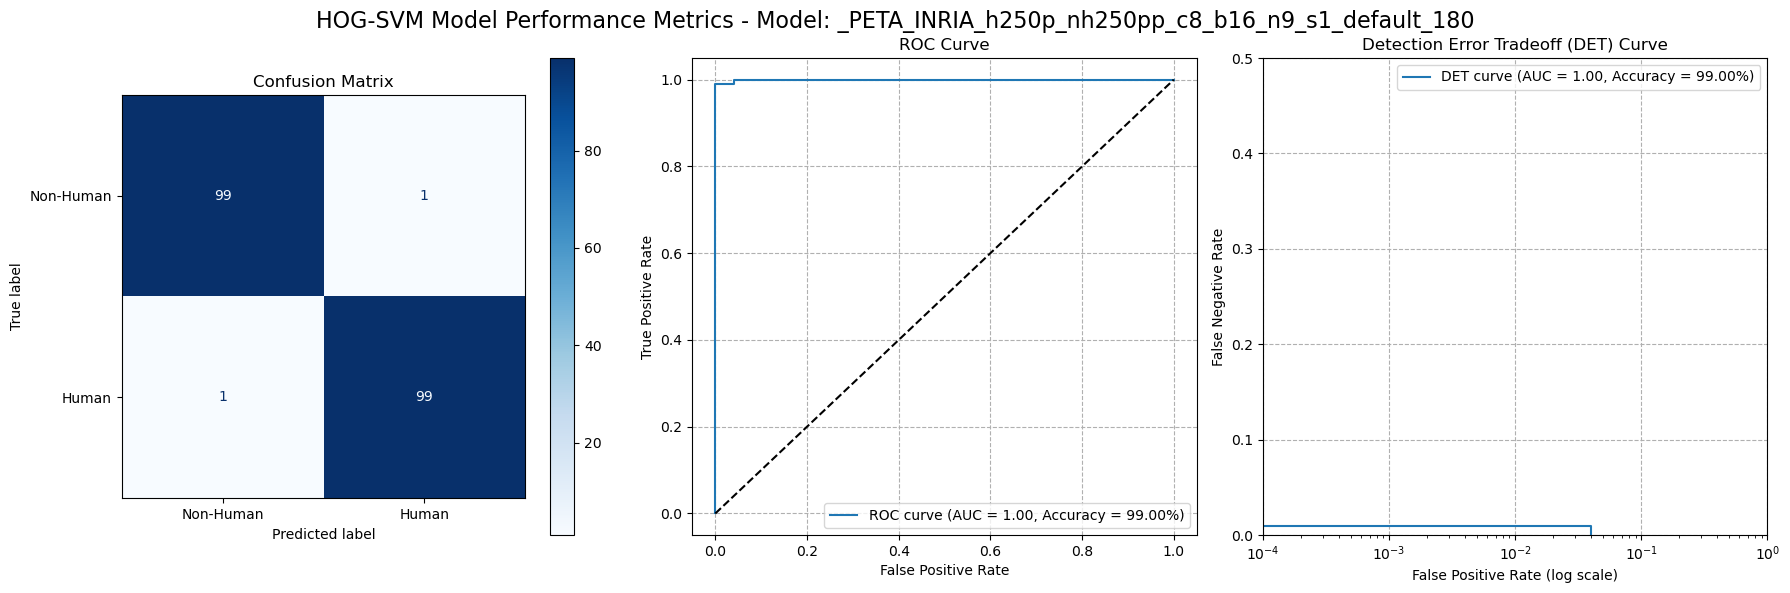

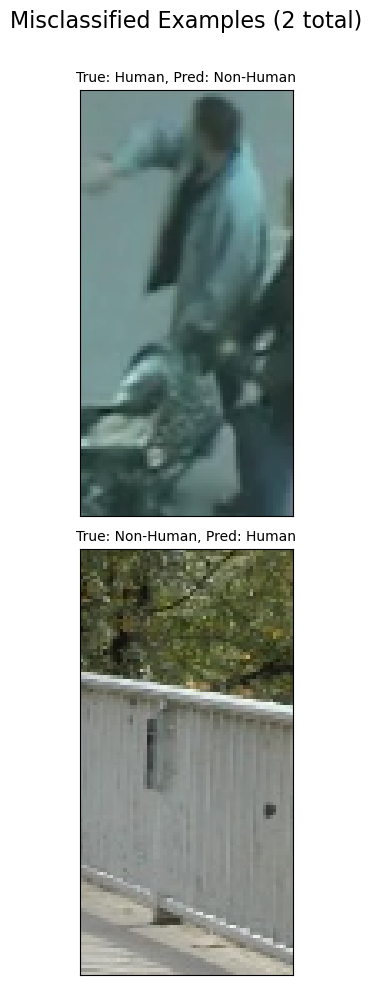


Performance at different thresholds:
Threshold	TPR		FPR		Accuracy
--------------------------------------------------
-2.00		1.0000	0.9100	0.5450
-1.00		1.0000	0.3100	0.8450
-0.50		1.0000	0.1000	0.9500
+0.00		0.9900	0.0100	0.9900
^ This is equivalent to the SVM's default threshold
+0.50		0.9600	0.0000	0.9800
+1.00		0.6800	0.0000	0.8400
+2.00		0.1100	0.0000	0.5550


In [41]:
model_suffix = "_PETA_INRIA_h250p_nh250pp_c8_b16_n9_s1_default_180"  # Model Suffix
test_dataset = "perfect_100" 
use_default_hog = True 

test_single_model(model_suffix, test_dataset, None)

The model performs very well here, as expected, since it was tested on an “easy” or less diverse dataset—images similar to those it was trained on.

This 99% accuracy prompted us to **create additional test sets** containing more diverse and imperfect data, with twice as many images. We need the model to perform worse during testing in order to clearly observe the impact of changes to the training data. When accuracy is too high, there’s not enough variation to meaningfully compare models or measure how much better one is than another.

---

Now we will test multiple models. Here, we’ll evaluate models trained with **default parameters** on **different datasets** to determine which training data performs best.

### 2. Compare default models 

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from pathlib import Path
import pandas as pd

output_dir = Path("outputs")
output_dir.mkdir(exist_ok=True)

# Models to test
models_to_test = [
    "_PETA_h250p_nh250patches_c8_b16_n9_s1_default_180",
    "_PETA_INRIA_h250u:h250p_nh500pp_c8_b16_n9_s1_default_180",
    "_PETA_INRIA_h500p_nh500pp_c8_b16_n9_s1_default_180", 
    "_PETA_INRIA_h250p_nh250pp_c8_b16_n9_s1_default_180",
    "_PETA_INRIA_h800p:h200u_nh800pp:nh200pat_c8_b16_n9_s1_default_180", 
    "_PETA_INRIA_h800p:h200u_nh1000pp_c8_b16_n9_s1_default_180"
]

# Create shorter model names for legend
model_short_names = {
    models_to_test[0]: "PETA 250p:250patches",
    models_to_test[1]: "PETA+INRIA 250u:250p 500pp",
    models_to_test[2]: "PETA+INRIA 500p 500pp",
    models_to_test[3]: "PETA+INRIA 250p 250pp",
    models_to_test[4]: "PETA+INRIA 800p:200u 800pp:200patches",
    models_to_test[5]: "PETA+INRIA 800p:200u 1000pp"
}

# Testing on both datasets, an easy and a hard one
test_datasets = [
    "perfect_200",
    "unperfect_200"
]

We will be testing our final model on a more challenging dataset (unperfect_200), which includes edge cases such as images showing a single arm or leg (labeled as non-human), images with more than half of a human figure (labeled as human), and images containing multiple people (also labeled as human). **The goal is to evaluate which training datasets produce models that can accurately classify difficult or ambiguous images—while also cross-checking that performance remains high on easier, more typical examples.**

In [43]:
results = {}
roc_data = {}

def evaluate_and_capture_results(model_suffix, test_dataset):
    """Run model evaluation and capture results for ROC curve generation"""
    print(f"Testing model ({models_to_test.index(model_suffix) + 1}/{len(models_to_test)}) {model_suffix}  on {test_dataset}")
    
    with redirect_stdout(open(os.devnull, 'w')):
        result = evaluate_model(model_suffix, test_dataset, hog_params=None, return_predictions=True, use_backup_if_available=True)

    if result:
        y_true, y_scores = result
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        
        # Calculate accuracy using default threshold (0)
        y_pred = (y_scores > 0).astype(int)
        accuracy = np.mean(y_true == y_pred)
        
        key = f"{model_suffix}_{test_dataset}"
        roc_data[key] = {
            'fpr': fpr,
            'tpr': tpr, 
            'auc': roc_auc,
            'model': model_suffix,
            'dataset': test_dataset
        }
        
        results[key] = {
            'model': model_suffix,
            'dataset': test_dataset,
            'accuracy': accuracy,
            'auc': roc_auc,
            'model_nickname': model_short_names[model_suffix]  # Added model nickname
        }
        
        return True
    
    return False

Testing model (1/6) _PETA_h250p_nh250patches_c8_b16_n9_s1_default_180  on perfect_200
Testing model (1/6) _PETA_h250p_nh250patches_c8_b16_n9_s1_default_180  on unperfect_200
Testing model (2/6) _PETA_INRIA_h250u:h250p_nh500pp_c8_b16_n9_s1_default_180  on perfect_200
Testing model (2/6) _PETA_INRIA_h250u:h250p_nh500pp_c8_b16_n9_s1_default_180  on unperfect_200
Testing model (3/6) _PETA_INRIA_h500p_nh500pp_c8_b16_n9_s1_default_180  on perfect_200
Testing model (3/6) _PETA_INRIA_h500p_nh500pp_c8_b16_n9_s1_default_180  on unperfect_200
Testing model (4/6) _PETA_INRIA_h250p_nh250pp_c8_b16_n9_s1_default_180  on perfect_200
Testing model (4/6) _PETA_INRIA_h250p_nh250pp_c8_b16_n9_s1_default_180  on unperfect_200
Testing model (5/6) _PETA_INRIA_h800p:h200u_nh800pp:nh200pat_c8_b16_n9_s1_default_180  on perfect_200
Testing model (5/6) _PETA_INRIA_h800p:h200u_nh800pp:nh200pat_c8_b16_n9_s1_default_180  on unperfect_200
Testing model (6/6) _PETA_INRIA_h800p:h200u_nh1000pp_c8_b16_n9_s1_default_180  o

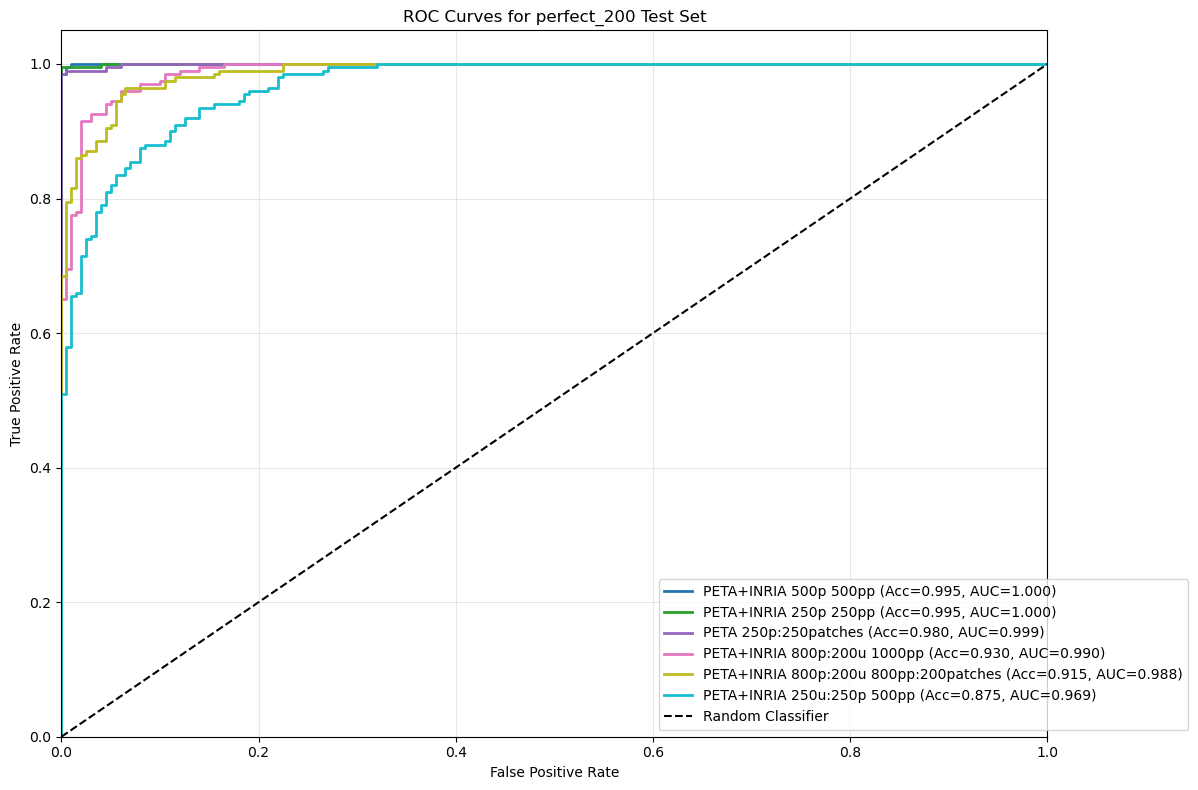

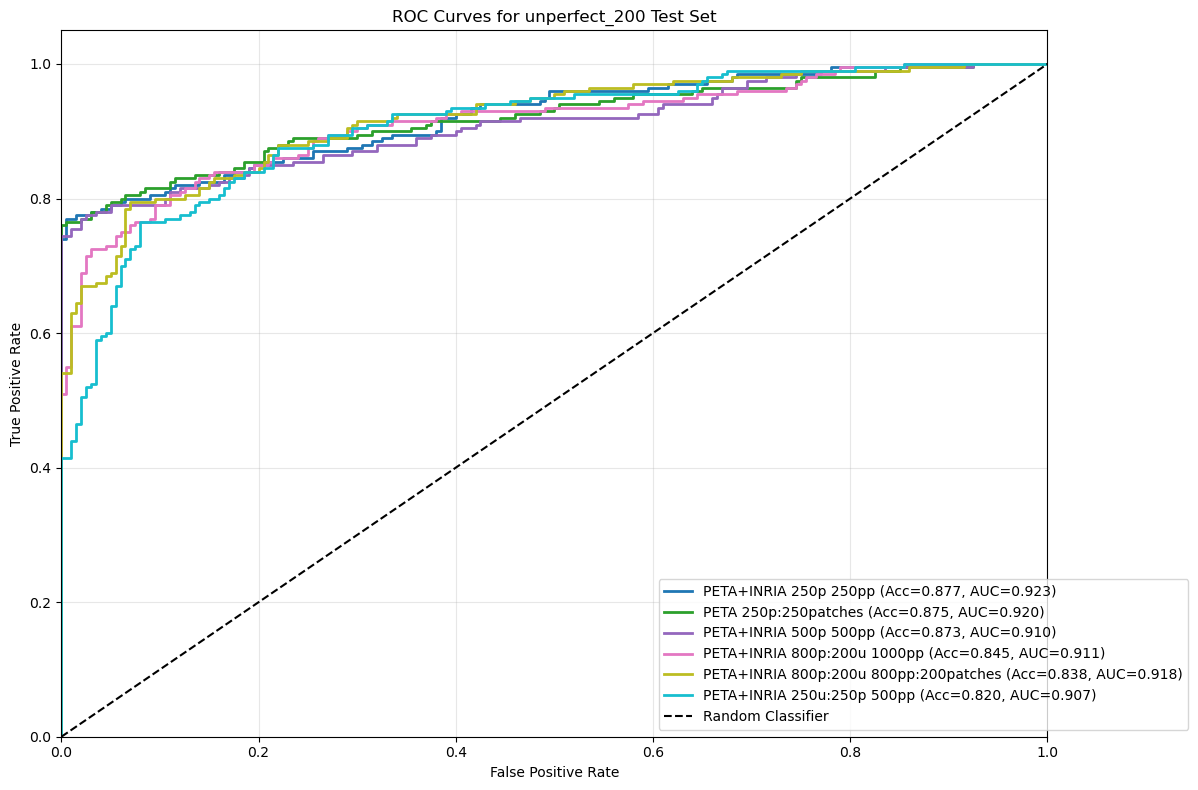

In [44]:
# Run evaluations
for model in models_to_test:
    for dataset in test_datasets:
        evaluate_and_capture_results(model, dataset)

# Create a separate plot for each test dataset
for dataset in test_datasets:
    plt.figure(figsize=(12, 8))
    
    # Color map for different models
    colors = plt.cm.tab10(np.linspace(0, 1, len(models_to_test)))
    
    # Create legend handles and labels
    legend_handles = []
    legend_labels = []
    
    # Sort models by accuracy for this dataset
    dataset_models = [(model, results[f"{model}_{dataset}"]['accuracy']) 
                     for model in models_to_test 
                     if f"{model}_{dataset}" in results]
    dataset_models.sort(key=lambda x: x[1], reverse=True)
    
    # Add ROC curves for this dataset in order of decreasing accuracy
    for i, (model, _) in enumerate(dataset_models):
        key = f"{model}_{dataset}"
        data = roc_data[key]
        line, = plt.plot(
            data['fpr'], 
            data['tpr'], 
            color=colors[i],
            linewidth=2
        )
        legend_handles.append(line)
        # Use shorter model name in legend with both accuracy and AUC
        legend_labels.append(
            f"{model_short_names[model]} (Acc={results[key]['accuracy']:.3f}, AUC={results[key]['auc']:.3f})"
        )
        # Add model nickname to results
        results[key]['model_nickname'] = model_short_names[model]
    
    # Add diagonal line for random classifier
    random_line, = plt.plot([0, 1], [0, 1], 'k--')
    legend_handles.append(random_line)
    legend_labels.append('Random Classifier')
    
    # Style the plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for {dataset} Test Set')
    
    # Adjust legend position and size
    plt.legend(legend_handles, legend_labels, loc="lower right", bbox_to_anchor=(1.15, 0))
    plt.grid(True, alpha=0.3)
    
    # Adjust layout to prevent legend cutoff
    plt.tight_layout()
    
    # Save the figure with extra space for legend
    plt.savefig(output_dir / f'roc_comparison_{dataset}.png', dpi=300, bbox_inches='tight', pad_inches=0.5)
    
    # Display the plot
    plt.show()

In [45]:
# printing and saving a summary of model performance 
summary_df = pd.DataFrame.from_dict(results, orient='index').reset_index(drop=True)
display(summary_df)

summary_df.to_csv(output_dir / 'model_evaluation_results.csv', index=False)

print(f"Evaluation complete! Results saved to '{output_dir}/model_evaluation_results.csv' and ROC plots saved to '{output_dir}/roc_comparison_*.png'")

,model,dataset,accuracy,auc,model_nickname
0,_PETA_h250p_nh250patches_c8_b16_n9_s1_default_180,perfect_200,0.9800,0.999450,PETA 250p:250patches
1,_PETA_h250p_nh250patches_c8_b16_n9_s1_default_180,unperfect_200,0.8750,0.920250,PETA 250p:250patches
2,_PETA_INRIA_h250u:h250p_nh500pp_c8_b16_n9_s1_d...,perfect_200,0.8750,0.968825,PETA+INRIA 250u:250p 500pp
3,_PETA_INRIA_h250u:h250p_nh500pp_c8_b16_n9_s1_d...,unperfect_200,0.8200,0.906775,PETA+INRIA 250u:250p 500pp
4,_PETA_INRIA_h500p_nh500pp_c8_b16_n9_s1_default...,perfect_200,0.9950,0.999900,PETA+INRIA 500p 500pp
5,_PETA_INRIA_h500p_nh500pp_c8_b16_n9_s1_default...,unperfect_200,0.8725,0.909850,PETA+INRIA 500p 500pp
6,_PETA_INRIA_h250p_nh250pp_c8_b16_n9_s1_default...,perfect_200,0.9950,0.999800,PETA+INRIA 250p 250pp
7,_PETA_INRIA_h250p_nh250pp_c8_b16_n9_s1_default...,unperfect_200,0.8775,0.922850,PETA+INRIA 250p 250pp
8,_PETA_INRIA_h800p:h200u_nh800pp:nh200pat_c8_b1...,perfect_200,0.9150,0.988050,PETA+INRIA 800p:200u 800pp:200patches
9,_PETA_INRIA_h800p:h200u_nh800pp:nh200pat_c8_b1...,unperfect_200,0.8375,0.918250,PETA+INRIA 800p:200u 800pp:200patches


Evaluation complete! Results saved to 'outputs/model_evaluation_results.csv' and ROC plots saved to 'outputs/roc_comparison_*.png'


In [46]:
# Print perfect dataset results ordered by accuracy
print("\nPerfect Dataset - Ordered by Accuracy:")
perfect_df = summary_df[summary_df['dataset'] == 'perfect_200'].sort_values('accuracy', ascending=False)
display(perfect_df[['model_nickname', 'accuracy']])

# Print perfect dataset results ordered by AUC
print("\nPerfect Dataset - Ordered by AUC:")
perfect_df = summary_df[summary_df['dataset'] == 'perfect_200'].sort_values('auc', ascending=False)
display(perfect_df[['model_nickname', 'auc']])

# Print unperfect dataset results ordered by accuracy
print("\nUnperfect Dataset - Ordered by Accuracy:")
unperfect_df = summary_df[summary_df['dataset'] == 'unperfect_200'].sort_values('accuracy', ascending=False)
display(unperfect_df[['model_nickname', 'accuracy']])

# Print unperfect dataset results ordered by AUC
print("\nUnperfect Dataset - Ordered by AUC:")
unperfect_df = summary_df[summary_df['dataset'] == 'unperfect_200'].sort_values('auc', ascending=False)
display(unperfect_df[['model_nickname', 'auc']])


Perfect Dataset - Ordered by Accuracy:


,model_nickname,accuracy
4,PETA+INRIA 500p 500pp,0.995
6,PETA+INRIA 250p 250pp,0.995
0,PETA 250p:250patches,0.980
10,PETA+INRIA 800p:200u 1000pp,0.930
8,PETA+INRIA 800p:200u 800pp:200patches,0.915
2,PETA+INRIA 250u:250p 500pp,0.875



Perfect Dataset - Ordered by AUC:


,model_nickname,auc
4,PETA+INRIA 500p 500pp,0.999900
6,PETA+INRIA 250p 250pp,0.999800
0,PETA 250p:250patches,0.999450
10,PETA+INRIA 800p:200u 1000pp,0.989600
8,PETA+INRIA 800p:200u 800pp:200patches,0.988050
2,PETA+INRIA 250u:250p 500pp,0.968825



Unperfect Dataset - Ordered by Accuracy:


,model_nickname,accuracy
7,PETA+INRIA 250p 250pp,0.8775
1,PETA 250p:250patches,0.8750
5,PETA+INRIA 500p 500pp,0.8725
11,PETA+INRIA 800p:200u 1000pp,0.8450
9,PETA+INRIA 800p:200u 800pp:200patches,0.8375
3,PETA+INRIA 250u:250p 500pp,0.8200



Unperfect Dataset - Ordered by AUC:


,model_nickname,auc
7,PETA+INRIA 250p 250pp,0.922850
1,PETA 250p:250patches,0.920250
9,PETA+INRIA 800p:200u 800pp:200patches,0.918250
11,PETA+INRIA 800p:200u 1000pp,0.911450
5,PETA+INRIA 500p 500pp,0.909850
3,PETA+INRIA 250u:250p 500pp,0.906775


## Discussion

Interestingly, models with less variation in training data and smaller training sets do better on the Hard dataset, despite not being trained on Hard images. 

In this case the best performing model was 250 ideal human training images and 250 ideal non-human training images. Including more training image and images that contained parts of humnans or multiple humans performed worse.

Let's see what images it got wrong

Loading model from /Users/lainemulvay/Desktop/Projects/UNI/cits4402/Research Proj/HOG-for-Human-Detection/Models/svm_hog_classifier_PETA_INRIA_h250p_nh250pp_c8_b16_n9_s1_default_180.joblib...
Error loading primary model: 118
Attempting to load backup file: /Users/lainemulvay/Desktop/Projects/UNI/cits4402/Research Proj/HOG-for-Human-Detection/Models/svm_hog_classifier_PETA_INRIA_h250p_nh250pp_c8_b16_n9_s1_default_180.joblib.backup
Backup model loaded successfully

=== MODEL EVALUATION ===

Model: svm_hog_classifier_PETA_INRIA_h250p_nh250pp_c8_b16_n9_s1_default_180.joblib
Backup file available: svm_hog_classifier_PETA_INRIA_h250p_nh250pp_c8_b16_n9_s1_default_180.joblib.backup
Test dataset: unperfect_200
Human test images: /Users/lainemulvay/Desktop/Projects/UNI/cits4402/Research Proj/HOG-for-Human-Detection/Datasets/Test/unperfect_200/human_test
Non-human test images: /Users/lainemulvay/Desktop/Projects/UNI/cits4402/Research Proj/HOG-for-Human-Detection/Datasets/Test/unperfect_200/non_hu

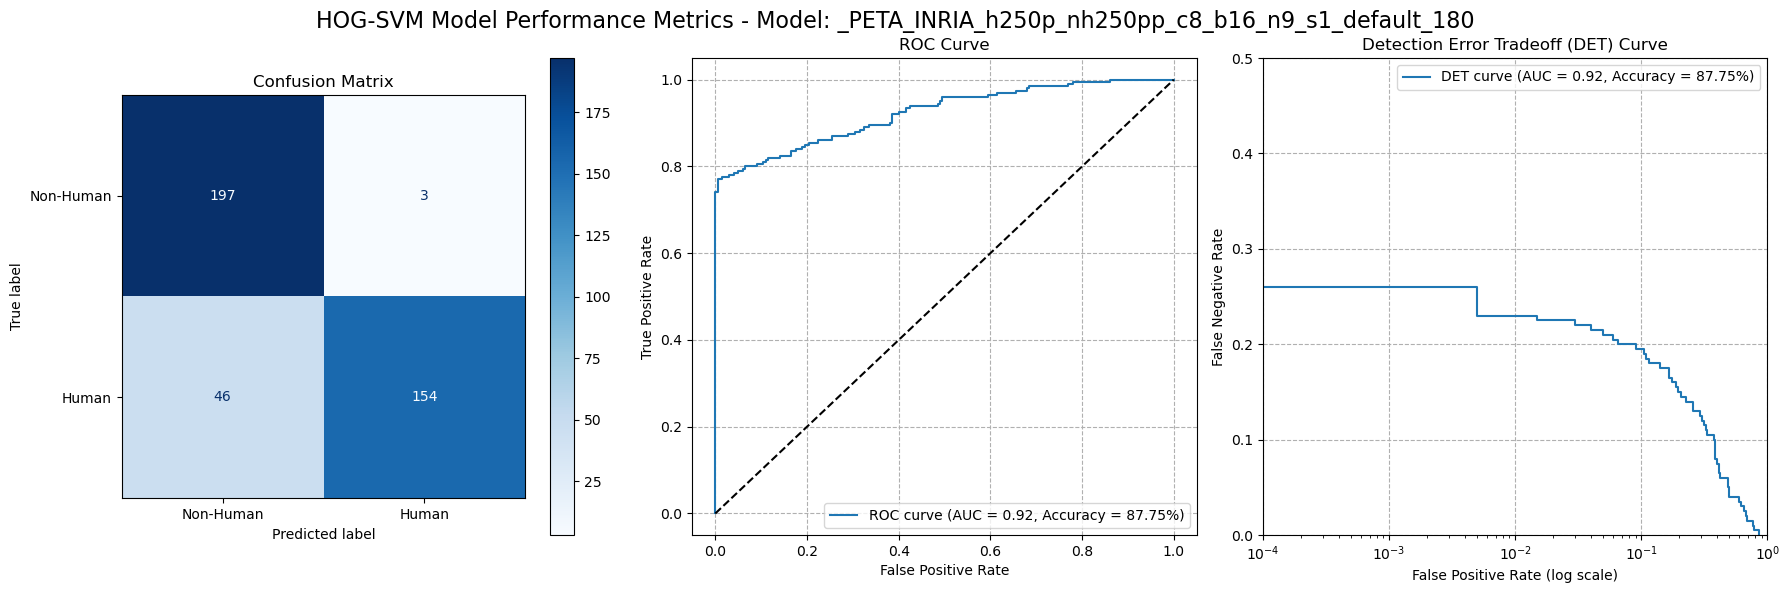

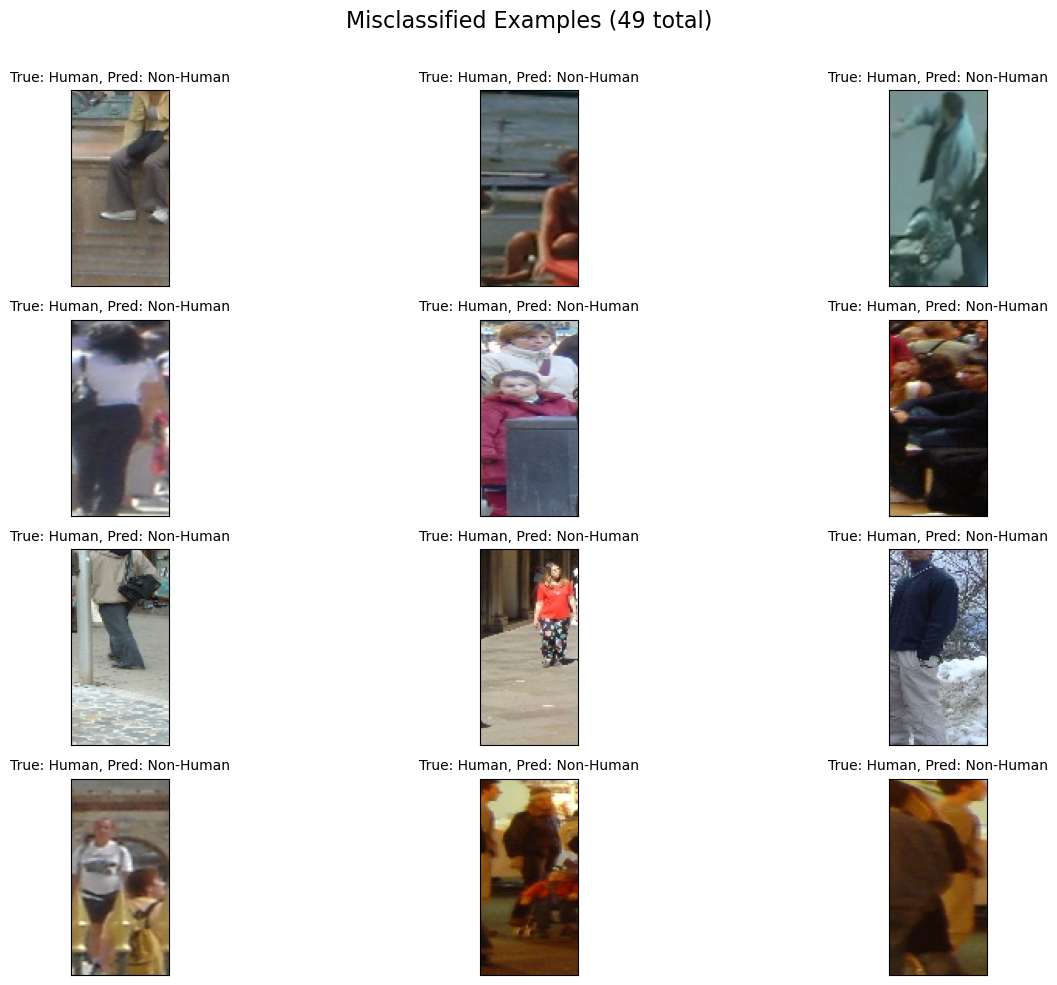


Performance at different thresholds:
Threshold	TPR		FPR		Accuracy
--------------------------------------------------
-2.00		1.0000	0.9150	0.5425
-1.00		0.8850	0.3200	0.7825
-0.50		0.8050	0.0950	0.8550
+0.00		0.7700	0.0150	0.8775
^ This is equivalent to the SVM's default threshold
+0.50		0.7200	0.0000	0.8600
+1.00		0.5250	0.0000	0.7625
+2.00		0.0700	0.0000	0.5350


In [47]:
model_suffix = "_PETA_INRIA_h250p_nh250pp_c8_b16_n9_s1_default_180"  # Model Suffix
test_dataset = "unperfect_200" 

test_single_model(model_suffix, test_dataset, None)

Interestingly, the model does well on non-human images, but struggles to classify an image as human when there is not a whole human in the image or there are multiple humans.

## Conclusion

The experiment of adding non-ideal images into the training set did not imporve performace, instead it reduced the models ability to correctly label ideal images, confusing the model.

**Therefore, our defualt model used for ablation studies will be:**

####    PETA+INRIA 250p 250pp (full name: svm_hog_classifier_final_train_c8_b16_n9_s1_default_180)